<a href="https://colab.research.google.com/github/MikFerrari/SMLHF_GoogleColabs/blob/main/2021_10_05_TP1_reinforcement_learning_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Ferlinghetti Enrico [21118263] 
- Ferrari Michele [21118273] 
- Strazzullo Alessandra [21118266]

# Outlook #

In this colab we will study basic reinforcement learning algorithms: TD learning, q-learning and sarsa. We will also investigate two basic exploration strategies: $\epsilon$-greedy and softmax.

# Installation #

In [ ]:
!pip install git+https://github.com/osigaud/SimpleMazeMDP

  Cloning https://github.com/osigaud/SimpleMazeMDP to /tmp/pip-req-build-3rlh_nwh
  Running command git clone -q https://github.com/osigaud/SimpleMazeMDP /tmp/pip-req-build-3rlh_nwh


In [ ]:
import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from mazemdp.toolbox import egreedy, egreedy_loc, softmax
from mazemdp.maze import build_maze, create_random_maze
from mazemdp.maze_plotter import show_videos
from mazemdp.mdp import Mdp

# For visualization
os.environ["VIDEO_FPS"] = "5"


# Customize Chrono class in file mazemdp.chrono.py

#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Author: Olivier Sigaud
Module: Chrono
Description: Class to display time spent in human format rather than seconds
"""

import time

class Chrono:
    def __init__(self):
        self.name = "Chrono"
        self.start = time.time()

    def stop(self) -> str:
        stop = time.time()
        dif = stop - self.start
        difstring = ""
        if dif > 3600:
            heures = int(dif / 3600)
            difstring = str(heures) + "h "
            dif = dif - (heures * 3600)
        if dif > 60:
            minutes = int(dif / 60)
            difstring = difstring + str(minutes) + "mn "
            dif = dif - (minutes * 60)
        difstring = difstring + str(int(dif)) + "s "
        dif = int((dif - int(dif)) * 1000)
        difstring = difstring + str(dif) + "ms"
        # print(f"Time : {difstring}")

        return difstring


# Reinforcement Learning #


Reinforcement Learning is about finding the optimal policy in an MDP which is initially unknown to the agent. More precisely, the state and action spaces are known, but the agent does not know the transition and reward functions. Generally speaking, the agent has to explore the MDP to figure out which action in which state leads to which other state and reward. The model-free case is about finding this optimal policy just through very local updates, without storing any information about previous interactions with the environment. Principles of these local updates can already be found in the Temporal Difference (TD) algorithm, which iteratively computes optimal values for all state using local updates.
The most widely used model-free RL algorithms are **q-learning**, **sarsa** and **actor-critic** algorithms. Below we focus on the first two.

As for dynamic programming, we first create a maze-like MDP. Reinforcement learning is slower than dynamic programming, so we will work with smaller mazes.

In [ ]:
from mazemdp import create_random_maze
# mdp = create_random_maze(5, 4, 0.2)
mdp = create_random_maze(5, 4, 0)

## Temporal Difference (TD) learning ##


Given a state and an action spaces as well as a policy, TD(0) computes the state value of this policy based on the following equations:
$$\delta_t = r(s_t,a_t) + \gamma V^{(t)}(s_{t+1})-V^{(t)}(s_t)$$
$$V^{(t+1)}(s_t) = V^{(t)}(s_t) + \alpha\delta_t$$

where $\delta$ is the TD error and $\alpha$ is a parameter called "learning rate".

The code is provided below, so that you can take inspiration later on. The important part is the computation of $\delta$, and the update of the values of $V$.

To run TD learning, a policy is needed as input. Such a policy can be retreived by using the `policy_iteration_q(mdp)` function defined in the dynamic programming notebook.

If you want to run this notebook independently, you can use instead the `random_policy` provided in `mazemdp`. This is what we do here by default, replace it if you want to run TD learning from an optimal policy.


In [ ]:
from mazemdp import random_policy

**Question:** In the code of the *temporal_difference(...)* function below, fill the missing parts with # some code = ... 



*The code provided here is compliant with the convention *openAIgym*, which asks to provide a *reset* and a *step* function*.
Two frameworks for RL:
- random, unlimited => the agent keeps searching until the episodes finishes
- episodic => when you reach the reward or a max amount of time, the agent is stopped and the episode terminates

An episode is the action performed by the agent between the code lines *reset* and *step*.

In [ ]:
def temporal_difference( mdp: Mdp, policy: np.ndarray, nb_episodes: int = 50,\
                        alpha: float = 0.2, timeout: int = 25, render: bool = True,\
                        ) -> np.ndarray:
    # alpha: learning rate
    # timeout: timeout of an episode (maximum number of timesteps)
    v = np.zeros(mdp.nb_states)  # initial state value v
    mdp.timeout = timeout

    if render:
        mdp.new_render("Temporal differences")

    for _ in tqdm(range(nb_episodes)):  # for each episode

        # Draw an initial state randomly (if uniform is set to False, the state is drawn according to the P0
        #                                 distribution)
        x = mdp.reset(uniform=True)
        done = mdp.done()
        while not done:  # update episode at each timestep
            # Show agent
            if render:
                mdp.render(v, policy)

            # Step forward following the MDP: x=current state,
            #                                 pol[i]=agent's action according to policy pol,
            #                                 r=reward gained after taking action pol[i],
            #                                 done=tells whether the episode ended,
            #                                 and info gives some info about the process
            [y, r, done, _] = mdp.step(egreedy_loc(policy[x], mdp.action_space.size, epsilon=0.2))

            # Update the state value of x
            if x in mdp.terminal_states:
                v[x] = r
                # v[x] += alpha*(r - v[x]) 
            else:
                # delta = ...
                delta = r + mdp.gamma*v[y] - v[x]
                # v[x] = ...
                v[x] += alpha*delta

            # Update agent's position (state)
            x = y

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.render(v, policy, title="Temporal Differences")
    return v

Once this is done, you can run it.

/usr/local/lib/python3.7/dist-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


  0%|          | 0/50 [00:00<?, ?it/s]

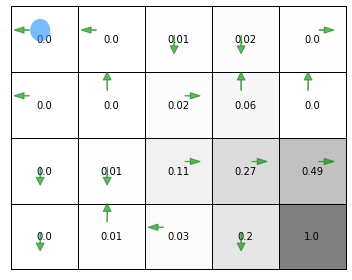

In [ ]:
policy = random_policy(mdp)
v = temporal_difference(mdp, policy)

/usr/local/lib/python3.7/dist-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


  0%|          | 0/50 [00:00<?, ?it/s]

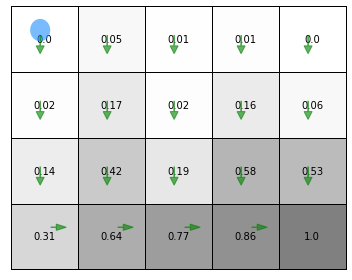

In [ ]:
# Re-run the same algorithm, but starting from an optimized policy
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs an already improved policy given the values of the Q function
    policy = np.argmax(q, axis=1)

    return policy

def evaluate_one_step_q(mdp: Mdp, q: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    qnew = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        for u in mdp.action_space.actions:
            if x not in mdp.terminal_states:
                # Process sum of the values of the neighbouring states
                # ...
                summ = 0
                for y in range(mdp.nb_states):
                    summ += mdp.P[x, u, y] * q[y, policy[y]]
                qnew[x, u] = mdp.r[x, u] + mdp.gamma*summ
            else:  # if the state is final, then we only take the reward into account
                # qnew[x, u] = ...
                qnew[x, u] = mdp.r[x, u]
    return qnew

def evaluate_q(mdp: Mdp, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy

    # Set timer and counter
    times = []
    iter = 0

    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    stop = False
    while not stop:
        # Start timer for the current iteration
        start_timer = time.time()

        qold = q.copy()
        # q = ...
        q = evaluate_one_step_q(mdp, qold, policy)

        iter += 1

        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            stop = True

        end_timer = time.time()
        times.append(end_timer - start_timer)

    avg_time = np.mean(np.array(times))

    return q, iter, avg_time

def policy_iteration_q(mdp: Mdp, render: bool = False) \
-> Tuple[np.ndarray, List[float], np.ndarray]:
    """policy iteration over the q function."""

    # Set timer and counter
    timer_tot = Chrono()
    times = []
    iter = 0
    iter_elem = 0
    
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    policy = random_policy(mdp)

    stop = False

    if render:
        mdp.new_render("Policy iteration Q")

    while not stop:
        # Start timer for the current iteration 
        start_timer_iter = time.time()

        qold = q.copy()

        if render:
            mdp.render(q, title="Policy iteration Q")

        # Step 1 : Policy evaluation
        # q = ...
        q, iter_elem_temp, avg_time_elem = evaluate_q(mdp, policy)

        iter_elem += iter_elem_temp
        iter += 1

        # Step 2 : Policy improvement
        # policy = ...
        policy = get_policy_from_q(q)

        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

        end_timer_iter = time.time()
        times.append(end_timer_iter-start_timer_iter)

    if render:
        mdp.render(q, get_policy_from_q(q), title="Policy iteration Q")

    tot_time = timer_tot.stop()
    avg_time = np.mean(np.array(times))

    return q, q_list, policy


policy = policy_iteration_q(mdp)[2]
v = temporal_difference(mdp, policy)

In [ ]:
show_videos("videos/", "Temporal")

Converting videos/Temporaldifferences.avi


## Q-learning ##


The **q-learning** algorithm accounts for an agent exploring an MDP and updating at each step a model of the state action-value function stored into a Q-table. It is updated as follows:

$$\delta_t = r(s_t,a_t) + \gamma \max_{a \in A} Q^{(t)}(s_{t+1},a)-Q^{(t)}(s_t,a_t)$$

$$Q^{(t+1)}(s_t,a_t) = Q^{(t)}(s_t,a_t) + \alpha \delta_t.$$


To visualize the policy, we need the `get_policy_from_q(q)` function that we defined in the dynamic programming notebook. Import it below.

In [ ]:
# Already imported above!

# def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values
    # ...

**Question:**  Fill the code of the `q_learning(...)` function below.

In [ ]:
# --------------------------- Q-Learning epsilon-greedy version -------------------------------#

# Given an exploration rate epsilon, the QLearning algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate


def q_learning_eps( mdp: Mdp, epsilon: float, nb_episodes: int = 20, \
                   timeout: int = 50, alpha: float = 0.5, render: bool = True,\
                   ) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.new_render("Q-learning e-greedy")

    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True)
        done = mdp.done()
        while not done:
            if render:
                # Show the agent in the maze
                mdp.render(q, q.argmax(axis=1))

            # Draw an action using an epsilon-greedy policy
            u = egreedy(q, x, epsilon)

            # Perform a step of the MDP
            # [y, r, done, _] = ...
            [y, r, done, _] = mdp.step(u)

            # Update the state-action value function with q-Learning
            if x in mdp.terminal_states:
                q[x, u] = r
                # q[x, u] += alpha*(r - q[x,u]) 
            else:
                # delta = ...
                delta = r + mdp.gamma*max(q[y,:]) - q[x, u]
                # q[x, u] = ...
                q[x, u] += alpha*delta

            # Update the agent position
            x = y
        q_list.append(np.linalg.norm(np.maximum(q, q_min)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.render(q, get_policy_from_q(q), title="Q-learning e-greedy")

    return q, q_list

And run it.

/usr/local/lib/python3.7/dist-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


  0%|          | 0/20 [00:00<?, ?it/s]

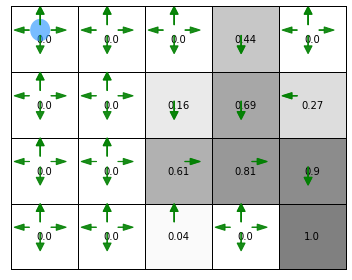

In [ ]:
epsilon = 0.02
q, q_list = q_learning_eps(mdp, epsilon)

In [ ]:
show_videos("videos/", "Q-learninge-greedy")

Converting videos/Q-learninge-greedy.avi


### Learning dynamics###


By watching carefully the values while the agent is learning, you can see that the agent favors certains paths over others which have a strictly equivalent value. This can be explained easily: as the agent chooses a path for the first time, it updates the values along that path, these values get higher than the surrounding values, and the agent chooses the same path again and again, increasing the phenomenon. Only steps of random exploration can counterbalance this effect, but they do so extremely slowly.

### Exploration ###


In the `q_learning(...)` function above, action selection is based on a `softmax` policy. Instead, it could have relied on *$\epsilon$-greedy*.

*In the GitHub Repository, functions from the toolbox.py are required for the softmax algorithm.*


**Question:** In the function below, you have to replace the call to the previous *$\epsilon$-greedy* policy with a `softmax` policy. The `softmax(...)` and `egreedy(...)` functions are available in `mazemdp.toolbox`.

In [ ]:
# --------------------------- Q-Learning softmax version ----------------------------#

# Given a temperature "tau", the QLearning algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate
def q_learning_soft(mdp: Mdp, tau: float, nb_episodes: int = 20, \
                    timeout: int = 50, alpha: float = 0.5, render: bool = True,\
                    ) -> Tuple[np.ndarray, List[float]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.new_render("Q-learning softmax")

    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True)
        done = mdp.done()
        
        while not done:
            if render:
                # Show the agent in the maze
                mdp.render(q, q.argmax(axis=1))

            # Draw an action using a soft-max policy
            # u = ... (here, call the softmax function)
            prob = softmax(q, x, tau)

            # the choiche of the action is performed according to the probability decided by softmax algorithm
            u = int(np.random.choice(mdp.action_space.actions, p=prob))

            # Copy-paste the rest from q_learning_eps...
            # Perform a step of the MDP
            # [y, r, done, _] = ...
            [y, r, done, _] = mdp.step(u)

            # Update the state-action value function with q-Learning
            if x in mdp.terminal_states:
                q[x, u] = r
                # q[x, u] += alpha*(r - q[x,u]) 
            else:
                # delta = ...
                delta = r + mdp.gamma*max(q[y,:]) - q[x, u]
                # q[x, u] = ...
                q[x, u] += alpha*delta

            # Update the agent position
            x = y
        q_list.append(np.linalg.norm(np.maximum(q, q_min)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.render(q, get_policy_from_q(q), title="Q-learning softmax")

    return q, q_list


Run this new version

/usr/local/lib/python3.7/dist-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


  0%|          | 0/20 [00:00<?, ?it/s]

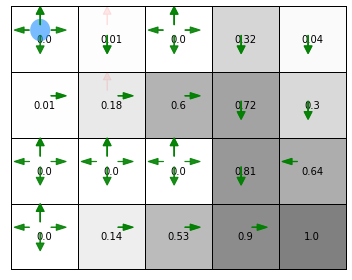

In [ ]:
epsilon = 0.02
q, q_list = q_learning_soft(mdp, epsilon)

In [ ]:
show_videos("videos/", "Q-learningsoftmax")

Converting videos/Q-learningsoftmax.avi


## Sarsa ##


The **sarsa** algorithm is very similar to **q-learning**. At first glance, the only difference is in the update rule. However, to perform the update in **sarsa**, one needs to know the action the agent will take when it will be at the next state, even if the agent is taking a random action.

This implies that the next state action is determined in advance and stored for being played at the next time step.


**Question:** Fill the code below

In [ ]:
# --------------------------- Sarsa, epsilon-greedy version -------------------------------#

# Given an exploration rate epsilon, the SARSA algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate
def sarsa_eps( mdp: Mdp, epsilon: float, nb_episodes: int = 20, \
              timeout: int = 50, alpha: float = 0.5, render: bool = True,\
              ) -> Tuple[np.ndarray, List[float]]:

    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.new_render("Sarsa e-greedy")

    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True)
        done = mdp.done()

        ux = egreedy(q, x, epsilon) # action u associated to the x state

        # Draw an action using an epsilon-greedy policy
        # Fill this part of the code
        while not done:
            if render:
                # Show the agent in the maze
                mdp.render(q, q.argmax(axis=1))

            # Draw an action using an epsilon-greedy policy
            # NO NEED TO RECALCULATE IT SINCE IT'S ALREADY PRESENT OUT OF THE WHILE LOOP

            # Perform a step of the MDP
            # [y, r, done, _] = ...
            [y, r, done, _] = mdp.step(ux) #action associated to the state, previously computed

            # Update the state-action value function with q-Learning
            if x in mdp.terminal_states:
                q[x, ux] = r
                # q[x, ux] += alpha*(r - q[x,ux]) 
            else:
                # computation of the future action
                uy = egreedy(q, y, epsilon) 
                # delta = ...
                delta = r + mdp.gamma * q[y,uy] - q[x, ux]
                # q[x, u] = ...
                q[x, ux] += alpha*delta


            # Update the agent position
            if x not in mdp.terminal_states:
                ux = uy # next action
            x = y # current action
                
        q_list.append(np.linalg.norm(np.maximum(q, q_min)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.render(q, get_policy_from_q(q), title="Sarsa e-greedy")
    return q, q_list

And run it.

/usr/local/lib/python3.7/dist-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


  0%|          | 0/20 [00:00<?, ?it/s]

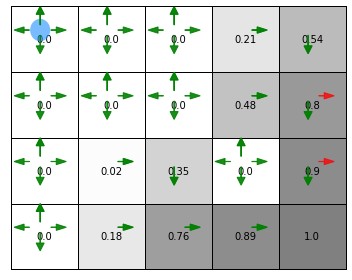

In [ ]:
epsilon = 0.02
q, q_list = sarsa_eps(mdp, epsilon)

In [ ]:
show_videos("videos/", "Sarsae")

Converting videos/Sarsae-greedy.avi


As for **q-learning** above, copy-paste the resulting code to get a *sarsa_soft(...)* and a *sarsa_eps(...)* function.

In [ ]:
# --------------------------- Sarsa, softmax version -------------------------------#

# Given a temperature "tau", the SARSA algorithm computes the state action-value function
# based on a softmax policy
# alpha is the learning rate
def sarsa_soft(mdp: Mdp, tau: float, nb_episodes: int = 20, timeout: int = 50,\
               alpha: float = 0.5, render: bool = True,) \
               -> Tuple[np.ndarray, List[float]]:

    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_min = np.zeros((mdp.nb_states, mdp.action_space.size))
    q_list = []

    # Run learning cycle
    mdp.timeout = timeout  # episode length

    if render:
        mdp.new_render("Sarsa softmax")

    for _ in tqdm(range(nb_episodes)):
        # Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True)
        done = mdp.done()

        # Draw an action using a soft-max policy
        # u = ... (here, call the softmax function)
        prob = softmax(q, x, tau)

        # the choiche of the action is performed according to the probability decided by softmax algorithm
        ux = int(np.random.choice(mdp.action_space.actions, p=prob))

        # Fill this part of the code

        while not done:
            if render:
                # Show the agent in the maze
                mdp.render(q, q.argmax(axis=1))

            # Draw an action using an epsilon-greedy policy
            # NO NEED TO RECALCULATE IT SINCE IT'S ALREADY PRESENT OUT OF THE WHILE LOOP

            # Perform a step of the MDP
            # [y, r, done, _] = ...
            [y, r, done, _] = mdp.step(ux) #action associated to the state, previously computed

            # Update the state-action value function with q-Learning
            if x in mdp.terminal_states:
                q[x, ux] = r
                # q[x, ux] += alpha*(r - q[x,ux]) 
            else:
                # computation of the future action
                prob = softmax(q, y, tau)
                # the choiche of the action is performed according to the probability decided by softmax algorithm
                uy = int(np.random.choice(mdp.action_space.actions, p=prob))

                # delta = ...
                delta = r + mdp.gamma * q[y,uy] - q[x, ux]
                # q[x, u] = ...
                q[x, ux] += alpha*delta

            # Update the agent position
            
            if x not in mdp.terminal_states:
                ux = uy # next action
            x = y # current action
                
        q_list.append(np.linalg.norm(np.maximum(q, q_min)))

    if render:
        # Show the final policy
        mdp.current_state = 0
        mdp.render(q, get_policy_from_q(q), title="Sarsa softmax")
    return q, q_list


And run it.

/usr/local/lib/python3.7/dist-packages/mazemdp/maze_plotter.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.axes_history.append(self.figure_history[-1].add_subplot(111))


  0%|          | 0/20 [00:00<?, ?it/s]

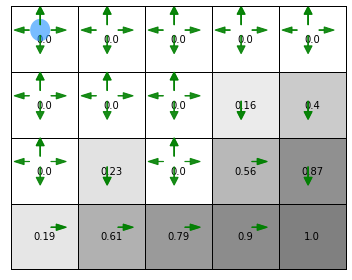

In [ ]:
epsilon = 0.02
q, q_list = sarsa_soft(mdp, epsilon)

In [ ]:
show_videos("videos/", "Sarsasoftmax")

Converting videos/Sarsasoftmax.avi


## Visualizations ##

Compare the number of steps needed by **q-learning** and **sarsa** to converge on the given MDP using the *softmax* and *$\epsilon$-greedy* exploration strategies. To figure out, use the provided `plot_ql_sarsa(m, epsilon, tau, nb_episodes, timeout, alpha, render)` function below with various values for $\epsilon$ (e.g. 0.001, 0.01, 0.1) and $\tau$ (e.g. 0.1, 5, 10) and comment the obtained curves.

In [ ]:
# -------- plot learning curves of Q-Learning and Sarsa using epsilon-greedy and softmax ----------#

def plot_ql_sarsa(m, epsilon, tau, nb_episodes, timeout, alpha, render):
    q, q_list1 = q_learning_eps(m, epsilon, nb_episodes, timeout, alpha, render)
    q, q_list2 = q_learning_soft(m, tau, nb_episodes, timeout, alpha, render)
    q, q_list3 = sarsa_eps(m, epsilon, nb_episodes, timeout, alpha, render)
    q, q_list4 = sarsa_soft(m, tau, nb_episodes, timeout, alpha, render)

    plt.clf()
    plt.plot(range(len(q_list1)), q_list1, label='q-learning epsilon')
    plt.plot(range(len(q_list2)), q_list2, label='q-learning tau')
    plt.plot(range(len(q_list3)), q_list3, label='sarsa epsilon')
    plt.plot(range(len(q_list4)), q_list4, label='sarsa tau')

    plt.xlabel('Number of episodes')
    plt.ylabel('Norm of Q values')
    plt.legend(loc='upper right')
    plt.savefig("comparison_RL.png")
    plt.title("Comparison of convergence rates")
    plt.show()

def plot_ql_sarsaSUBPLOT(m, epsilon, tau, nb_episodes, timeout, alpha, render, ax, x, y):
    q, q_list1 = q_learning_eps(m, epsilon, nb_episodes, timeout, alpha, render)
    q, q_list2 = q_learning_soft(m, tau, nb_episodes, timeout, alpha, render)
    q, q_list3 = sarsa_eps(m, epsilon, nb_episodes, timeout, alpha, render)
    q, q_list4 = sarsa_soft(m, tau, nb_episodes, timeout, alpha, render)

    #plt.clf()
    ax[x,y].plot(range(len(q_list1)), q_list1, label='q-learning epsilon')
    ax[x,y].plot(range(len(q_list2)), q_list2, label='q-learning tau')
    ax[x,y].plot(range(len(q_list3)), q_list3, label='sarsa epsilon')
    ax[x,y].plot(range(len(q_list4)), q_list4, label='sarsa tau')

    ax[x,y].set_title('epsilon: ' + str(epsilon) + ' tau: ' + str(tau) + 'alpha: '+ str(alpha))
    ax[x,y].grid()

    #ax[x,y].xlabel('Number of episodes')
    #ax[x,y].ylabel('Norm of Q values')
    if x==0 and y==0:
      ax[x,y].legend(loc='lower right')
    #ax[x,y].savefig("comparison_RL.png")
    #ax[x,y].title("Comparison of convergence rates")
    #ax[x,y].show()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

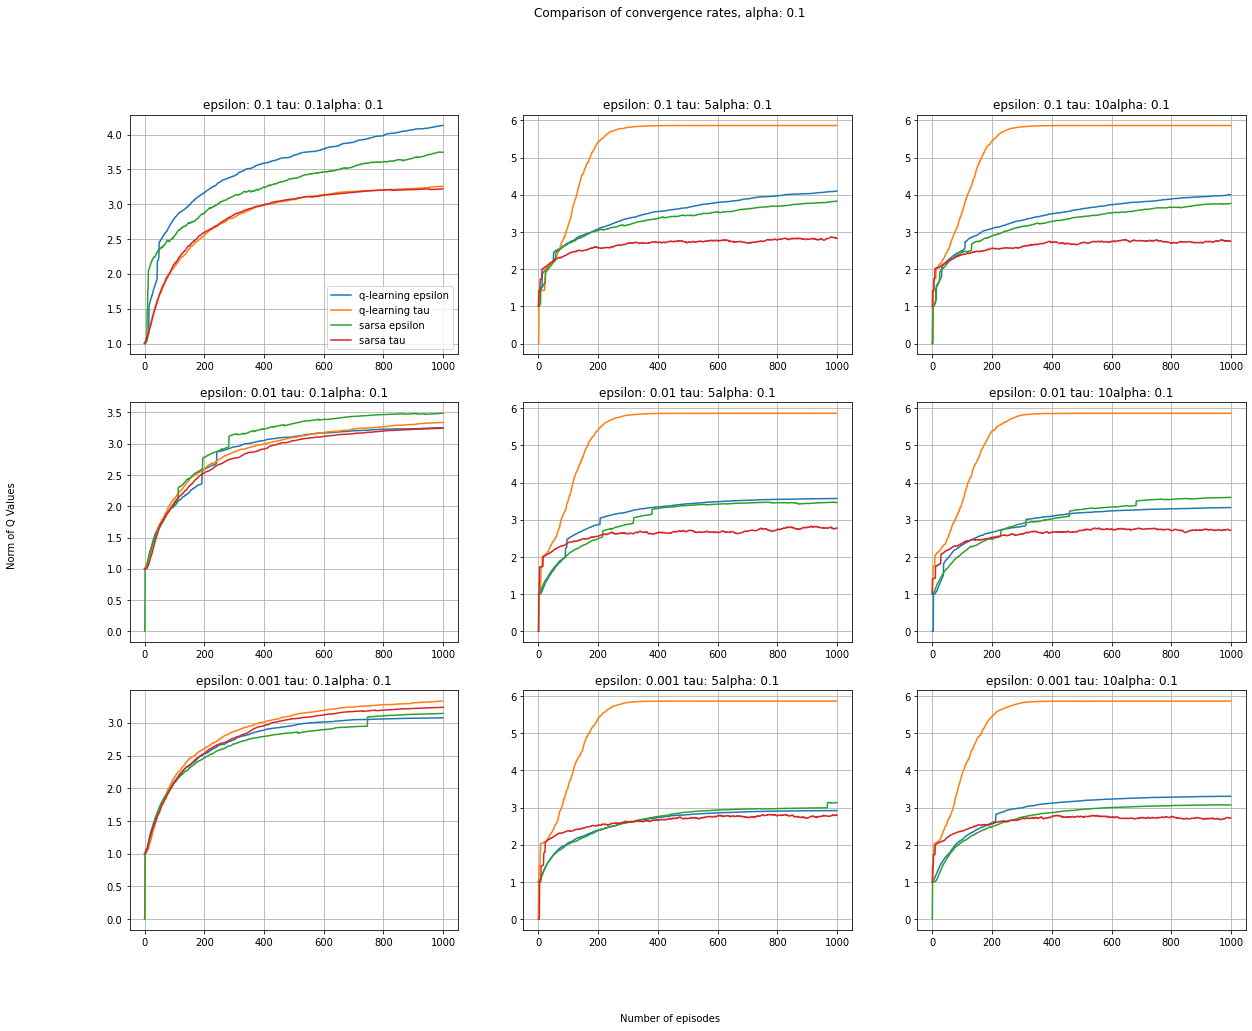

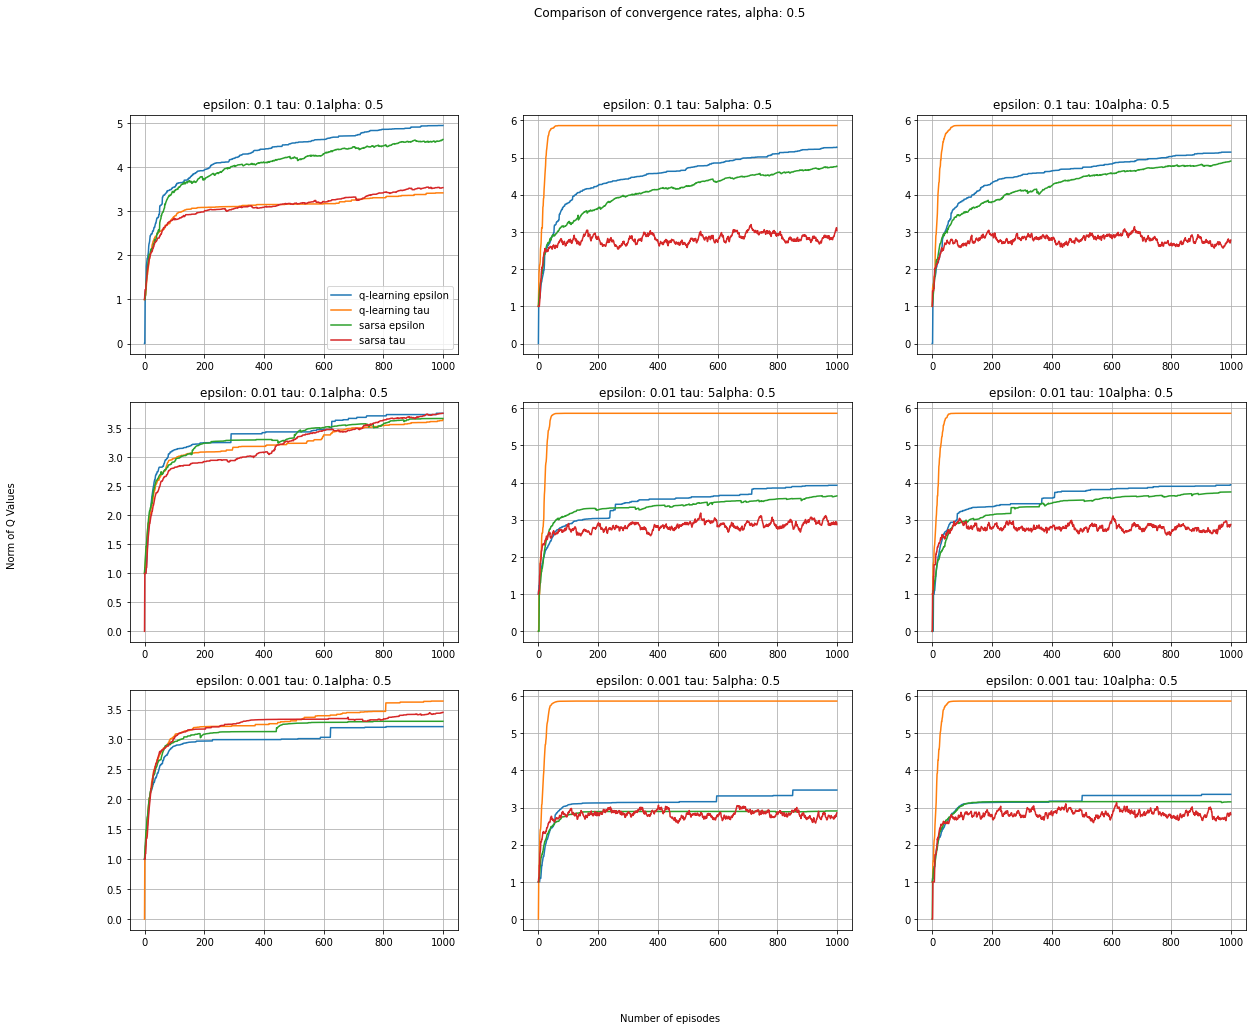

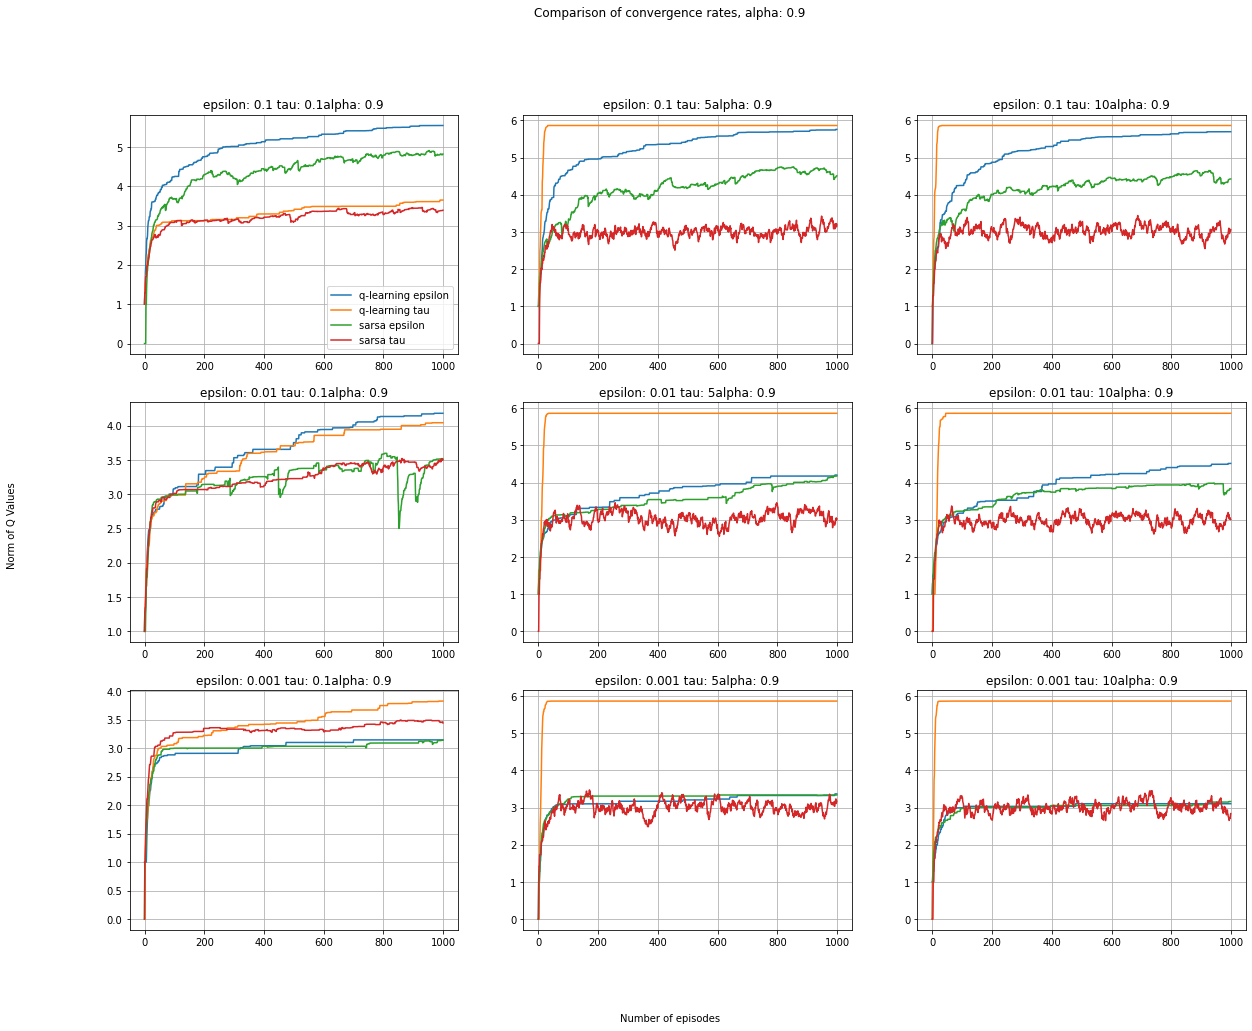

In [ ]:
epsilon_array = [0.1, 0.01, 0.001]
tau_array = [0.1, 5, 10]
alpha_array = [0.1, 0.5, 0.9]

for alpha in tqdm(alpha_array):
  fig, ax = plt.subplots(3,3)
  fig.set_size_inches(20,15)
  for epsilon in tqdm(epsilon_array):
    for tau in tqdm(tau_array):
      index_epsilon = epsilon_array.index(epsilon)
      index_tau = tau_array.index(tau)
      plot_ql_sarsaSUBPLOT(mdp, epsilon, tau, 1000, 50, alpha, False, ax, index_epsilon, index_tau)
      
  fig.text(0.5, 0.04,'Number of episodes', ha='center')
  fig.text(0.04, 0.5, 'Norm of Q Values', va='center', rotation='vertical')
  fig.suptitle("Comparison of convergence rates, alpha: " + str(alpha))
  plt.draw()

plt.show()

**Discussion**

The plots are organized as follows: 
- for three different values of the *learning rate* $\alpha$ (0.1, 0.5, 0.9),
  - three different values of the parameter $\epsilon$ ($10^{-1}, 10^{-2}, 10^{-3}$),
    - three different values of the *temperature* $\tau$ (0.1, 5, 10),


the convergence of the four methods is computed.

Actually, some preliminary observations should be done:
- q-learning $\tau$ & sarsa $\tau$ involve the application of the *softmax* algorithm, hence they are influenced by the values of $\tau$. Their evolution can be seen among different columns of the plot, whereas on the same row same results are attended. These results are not completely identical, since executions can be slighlty different.
- q-learning $\epsilon$ & sarsa $\epsilon$ involve the application of the *$\epsilon$-greedy algorithm*. Their evolution can be seen among different rows of the plot and on the same column, as before, same results are attended.

The following observations can be made:

- increasing the learning rate $\alpha$ from 0.1 to 5 and to 10, it is possible to see that:
  - all the algorithms are reaching the convergence faster;
  - all the algorithms become noisier and noisier, in particular this is very evident for the sarsa $\tau$. This means that stronger oscillations are introduced to the model: increasing the learning rate, more weight is associated to the $\delta$ term, the estimation error;
  - the norm of the Q values tends to increase except for the yellow line (q-learning $\tau$)

- increasing the value of $\tau$, only q-learning $\tau$ & sarsa $\tau$ are affected, consequently the analysis is performed observing the evolution of the yellow and red lines across different columns. 
  - if $\tau$ is equal to 0.1, there is no difference between the norm of the Q values of the two algorithms, they both reach more or less a value of three. Increasing $\tau$ to 5, the norm of Q values of q-learning $\tau$ settles to 6, whereas the one of sarsa $\tau$ is still at 3. A possible reason for this is that increasing the *temperature*, the probability distribution given by the *softmax* algorithm tends more and more to approximate a uniform distribution. Therefore, the choice of the next action is less oriented to the best action obtained so far and there is more space for exploration. 

- decreasing each time the value of $\epsilon$ of a factor of 10, only q-learning $\epsilon$ & sarsa $\epsilon$ are affected, consequently the analysis is performed observing the evolution of the green and blue lines across different rows.
  - decreasing the value of $\epsilon$, the norm of Q values decreases as well, since a reduced $\epsilon$ value means a lower chance of selecting a random action, limiting the exploration of the maze.



## Effect of hyper-parameters ##

When using *softmax*, the three main hyper-parameters of **q-learning** and **sarsa** are $\alpha$, $\tau$ (when using *softmax*) and $\gamma$. By varying the values of these hyper-parameters and watching the learning process and behavior of the agent, explain their impact on the algorithm. Using additional plotting functions will also be welcome.

First of all we define a plot function that concerns only the softmax algorithms

In [ ]:
def plot_ql_sarsaSUBPLOT_SOFTMAX_TAU_GAMMA(m, epsilon, tau, nb_episodes, timeout, alpha, gamma, render, ax, x, y):
    
    # storing the original value of mdp.gamma 
    gamma_old = mdp.gamma
    # modifying the mdp.gamma parameters directly in the mdp in order not to modify all the function
    mdp.gamma = gamma

    #q, q_list1 = q_learning_eps(m, epsilon, nb_episodes, timeout, alpha, render)
    q, q_list2 = q_learning_soft(m, tau, nb_episodes, timeout, alpha, render)
    #q, q_list3 = sarsa_eps(m, epsilon, nb_episodes, timeout, alpha, render)
    q, q_list4 = sarsa_soft(m, tau, nb_episodes, timeout, alpha, render)

    # restoring the mdp to its initial value
    mdp.gamma = gamma_old

    #plt.clf()
    #ax[x,y].plot(range(len(q_list1)), q_list1, label='q-learning epsilon')
    ax[x,y].plot(range(len(q_list2)), q_list2, label='q-learning tau')
    #ax[x,y].plot(range(len(q_list3)), q_list3, label='sarsa epsilon')
    ax[x,y].plot(range(len(q_list4)), q_list4, label='sarsa tau')

    ax[x,y].set_title('gamma: ' + str(gamma) + ' tau: ' + str(tau))
    ax[x,y].grid()

    #ax[x,y].xlabel('Number of episodes')
    #ax[x,y].ylabel('Norm of Q values')
    if x==0 and y==0:
      ax[x,y].legend(loc='lower right')
    #ax[x,y].savefig("comparison_RL.png")
    #ax[x,y].title("Comparison of convergence rates")
    #ax[x,y].show()

Then we define multiple iterations on the application of different values of $\alpha$, $\tau$ and $\gamma$.

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

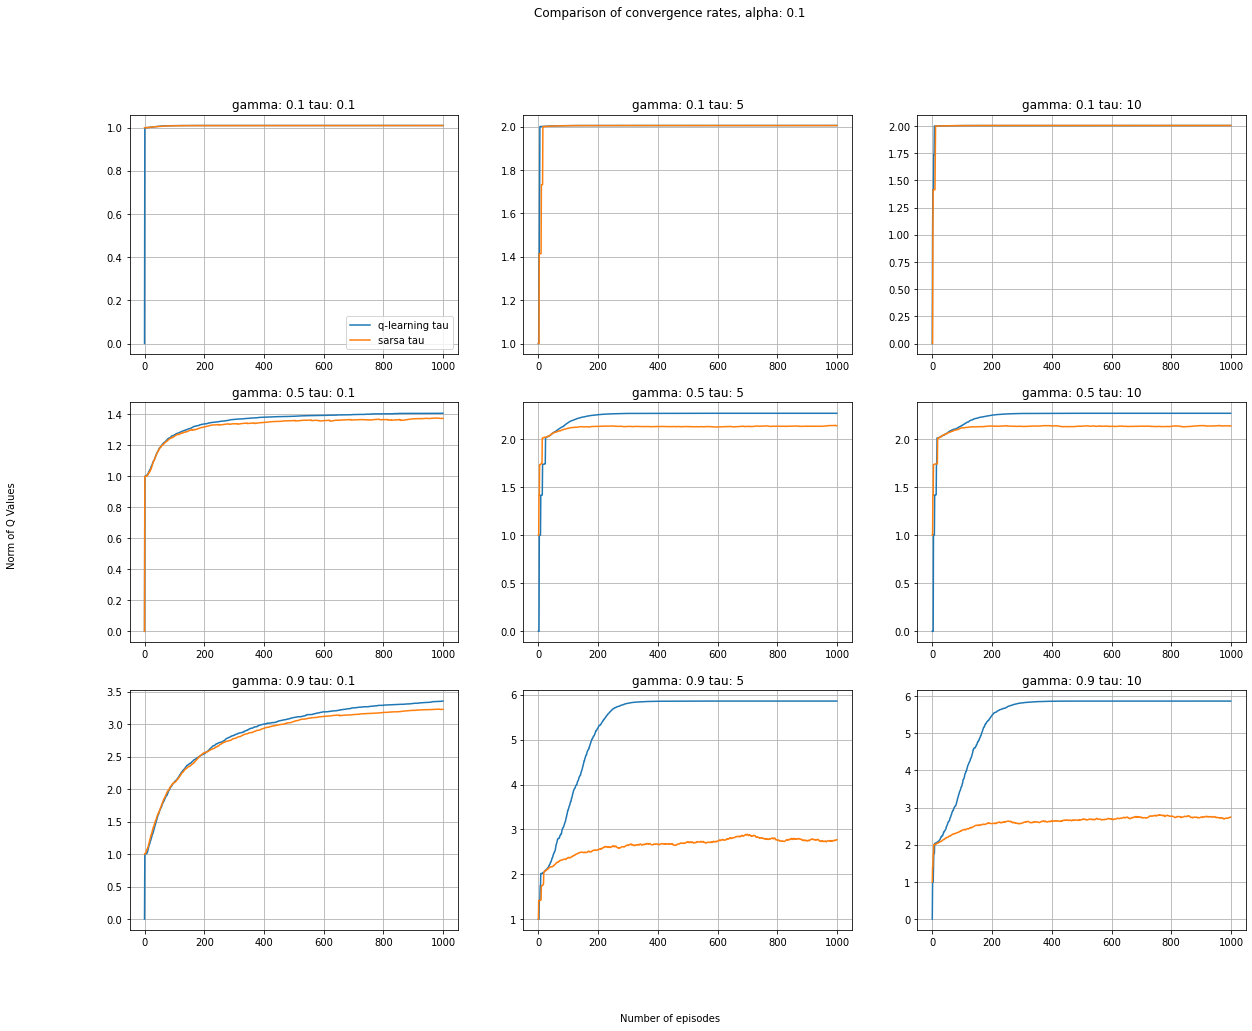

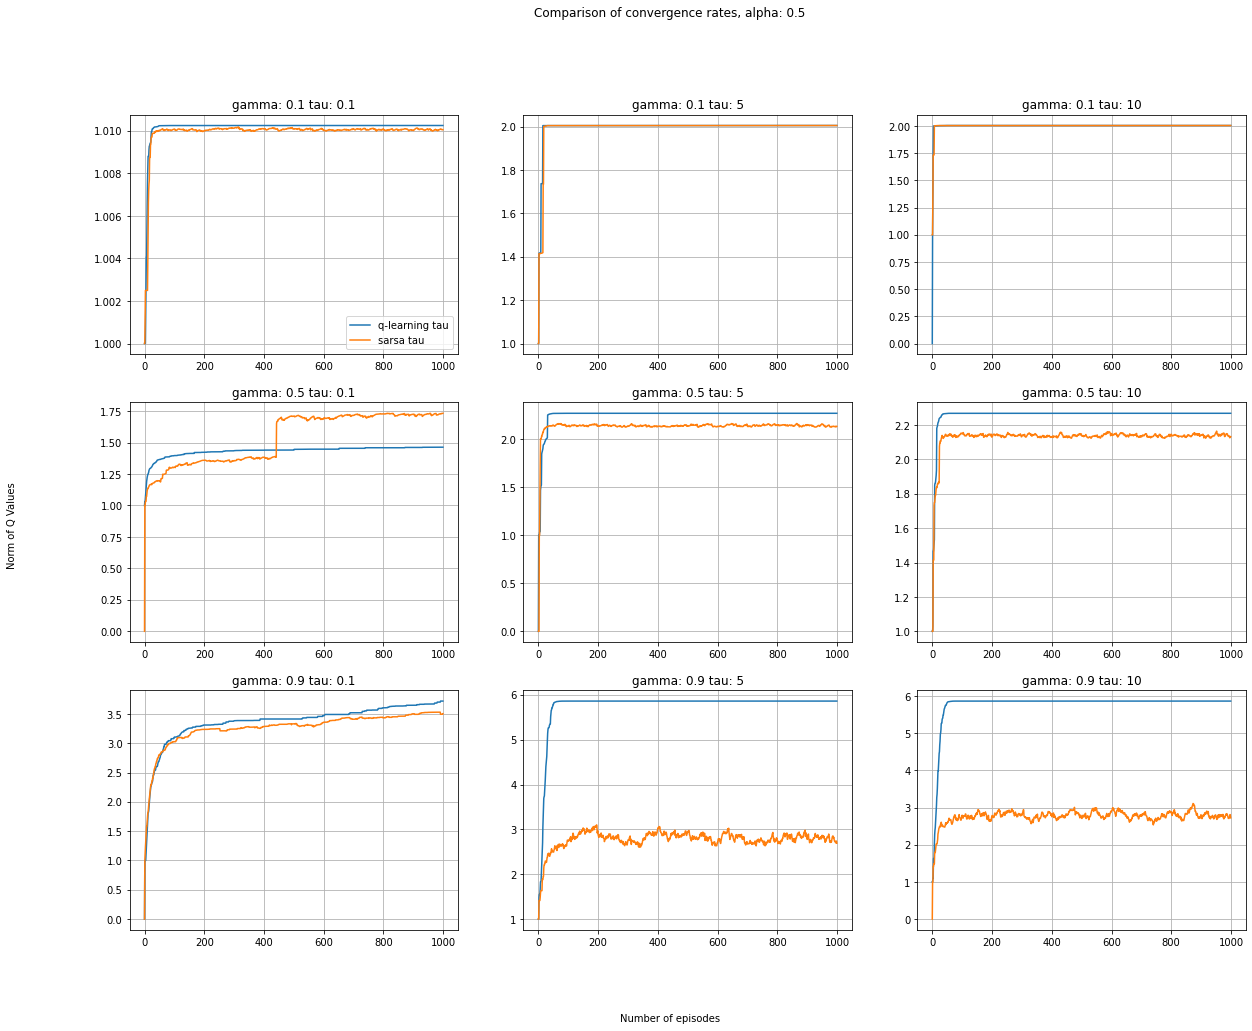

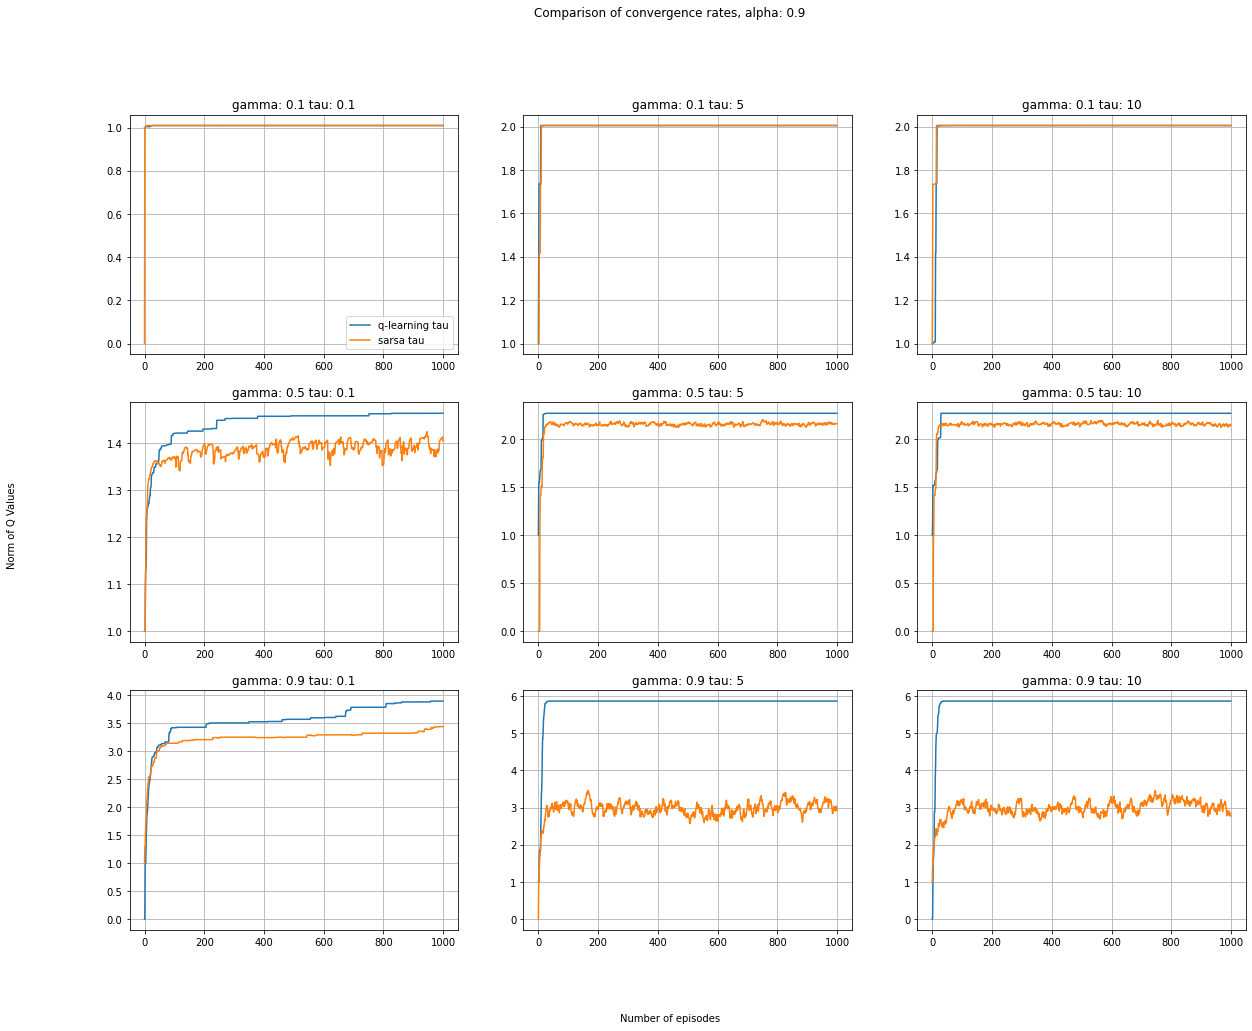

In [ ]:
alpha_array = [0.1, 0.5, 0.9] 
gamma_array = [0.1, 0.5, 0.9] 
tau_array = [0.1, 5, 10]

EPSILON_0 = 0 # doesn't interest in this case, left for coherence with the previous function



for alpha in tqdm(alpha_array):
  fig, ax = plt.subplots(3,3)
  fig.set_size_inches(20,15)
  for gamma in tqdm(gamma_array):
    for tau in tqdm(tau_array):
      index_gamma = gamma_array.index(gamma)
      index_tau = tau_array.index(tau)
      plot_ql_sarsaSUBPLOT_SOFTMAX_TAU_GAMMA(mdp, EPSILON_0, tau, 1000, 50, alpha, gamma, False, ax, index_gamma, index_tau)
      
  fig.text(0.5, 0.04,'Number of episodes', ha='center')
  fig.text(0.04, 0.5, 'Norm of Q Values', va='center', rotation='vertical')
  fig.suptitle("Comparison of convergence rates, alpha: " + str(alpha))
  plt.draw()

plt.show()

**Discussion**

The plots are organized as follows:

- for three different values of the learning rate α (0.1, 0.5, 0.9),
  - three different values of the parameter $\gamma$ (0.1, 0.5, 0.9),
    - three different values of the temperature τ (0.1, 5, 10),

the convergence of the two methods applying *softmax* is computed.

The following observations can be made:
- for the parameters $\alpha$ and $\tau$, the same reasoning applies;
- increasing the value of $\gamma$:
  - the general trend that can be observed is that the norm of Q values increases, in particular for the q-learning algorithm. 
  This is due to the fact that when $\gamma$ increases, the agent is more forward-looking and consequently there is more room for exploration.
  - moreover, the difference between the two algorithms gets more and more important, with q-learning reaching lower values. This can be explained looking at the term:
 $$ \gamma \max_{a \in A} Q^{(t)}(s_{t+1},a)$$ 
that weights more if $\gamma$ is bigger, forcing the change in the current q value.


